# Multiclass image classification - Traffic Sign Classification

Dataset: German Traffic Sign Dataset (http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) <br>
It contains 43 classes of images of different traffic signs. Images vary in size. <br> <br>
Training set size: 39209 <br>
Test set size: 12630 <br>

We will use only 20000 images for training and 4000 images for validation. <br>


### 1. Importing libraries

In [1]:
import os
import requests
import zipfile
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

2023-11-25 15:24:04.680173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. Defining global variables

In [2]:
DATA_DIR = "./data"
HOME_DIR = "./"
TRAIN_DOWNLOAD_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
TEST_DOWNLOAD_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip"
TEST_GT_DOWNLOAD_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip"
BATCH_SIZE = 32
VAL_SPLIT = 0.2
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
TUNING_EPOCHS = 20
EPOCHS = 50
NUM_CLASSES = 43

try:
    from google.colab import drive
    !pip install -U -q keras_tuner
    drive.mount('/content/drive')
    HOME_DIR = "/content/drive/My Drive/Colab Notebooks/ComputerVision/MulticlassClassification"
    DATA_DIR = os.path.join(HOME_DIR, "data")
except ImportError:
    print("Not running in Google Colab. Skipping Google Colab specific code.")

import keras_tuner as kt
TRAIN_DIR = os.path.join(DATA_DIR, "GTSRB/Final_Training/Images")
TEST_DIR = os.path.join(DATA_DIR, "GTSRB/Final_Test/Images")
TEST_GT_DIR = os.path.join(DATA_DIR, "GT-final_test.csv")

Not running in Google Colab. Skipping Google Colab specific code.


### 3. Downloading the data

It might take around 5 minutes to download the data.

In [3]:
def download_and_unzip(download_url, data_dir=DATA_DIR, finished_data_dir=None):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if not os.path.exists(finished_data_dir):
        print(f"Starting download from {download_url}")
        response_train = requests.get(download_url)

        if response_train.status_code == 200:
            zip_file_path = os.path.join(data_dir, "file.zip")
            with open(zip_file_path, "wb") as f:
                f.write(response_train.content)
            print(f"Download succesful. Saved to {data_dir}")

            with zipfile.ZipFile(zip_file_path, "r") as zip_f:
                zip_f.extractall(data_dir)

            os.remove(zip_file_path)
        else:
            print(f"Download unsuccesful. Status code: {response_train.status_code}")
    else:
        print(f"Data already exists in {finished_data_dir}")

In [4]:
download_and_unzip(TEST_DOWNLOAD_URL, finished_data_dir=TEST_DIR)
download_and_unzip(TRAIN_DOWNLOAD_URL, finished_data_dir=TRAIN_DIR)
download_and_unzip(TEST_GT_DOWNLOAD_URL, finished_data_dir=TEST_GT_DIR)

Data already exists in ./data/GTSRB/Final_Test/Images
Data already exists in ./data/GTSRB/Final_Training/Images
Data already exists in ./data/GT-final_test.csv


### 4. Preparing the data

Trainign data is structured in folders, each folder representing a class. <br>
Test data is in a single folder with no class labels. <br>

#### Preparing training data:
We will use `ImageDataGenerator` from `Keras.preprocessing`. <br>
Since the images are in different folders, we will use `flow_from_directory` method to create batches of images. <br>

Preprocessing steps: <br>
- Rescale images to 0-1 range
- Split the training data into training and validation sets
- Create batches of images of size `BATCH_SIZE`
- esize images to `IMG_HEIGHT` x `IMG_WIDTH`
- Use mode `"categorical"`, since we have more than 2 classes



#### Preparing test data:
We will preprocess the test data a little different, because we don't have folder structure <br>
so we could use `flow_from_directory` method. The `flow_from_dataframe` method messes up the labels, because <br>
`os.listdir(path)` return the list of files that is not ordered. <br>
Instead we will use regular keras preprocessig methods and save the data in numpy arrays. <br>
`ground_truth` is the list of labels for each image. <br>

We will use subset of 20000 images from the training set of hyperparametes and tuned final model. <br>
For validation we will use 4000 images from the training set. <br>


In [5]:
def train_val_tf_dataset(
    train_dir=TRAIN_DIR, val_split=VAL_SPLIT, batch_size=BATCH_SIZE
):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / 255, validation_split=val_split
    )

    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation",
    )

    return train_generator, validation_generator


def test_tf_dataset(test_dir=TEST_DIR, test_gt_dir=TEST_GT_DIR, batch_size=BATCH_SIZE):
    with open(test_gt_dir, "r") as f:
        df = pd.read_csv(f, sep=";")
        df["Filename"] = df["Filename"].apply(lambda x: os.path.join(test_dir, x))

    ground_truth = df["ClassId"].values

    data = []
    for img_path in df["Filename"]:
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
        )
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0
        data.append(img)

    return np.array(data), ground_truth

In [6]:
train_generator, validation_generator = train_val_tf_dataset()
test_dataset, ground_truth = test_tf_dataset()

train_baches_num = 20000 // BATCH_SIZE
val_baches_num = 4000 // BATCH_SIZE

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


# 5. Visualizing the data

We will visualize the first 25 images from the training set. <br>
To do that we will use `imshow` from `matplotlib.pyplot`. <br>

In [7]:
def plot_images(generator, n_images=9):
    x, y = generator.next()
    n = np.ceil(np.sqrt(n_images)).astype(np.int32)
    plt.figure(figsize=(10, 10))
    for i in range(0, n_images):
        image = x[i]
        label = np.argmax(y[i])
        plt.subplot(n, n, 1 + i)
        plt.title(label)
        plt.axis("off")
        plt.subplots_adjust(hspace=0.5)
        plt.imshow(image)
    plt.show()

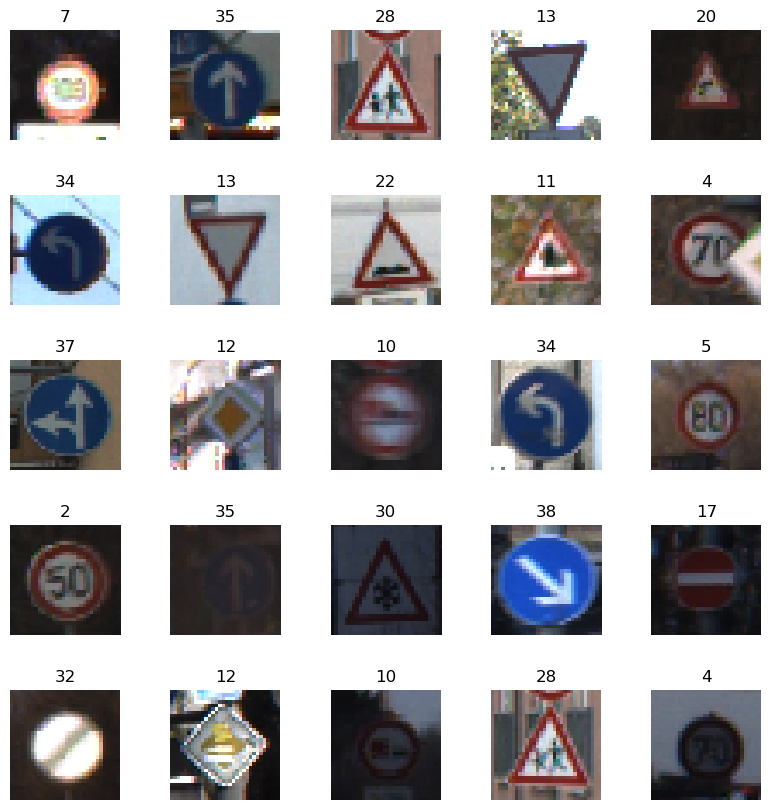

In [8]:
plot_images(train_generator, 25)

# 6. Creating the hypermodel

In [9]:
def model_builder(hp):
    model = Sequential()
    model.add(
        layers.Conv2D(
            filters=hp.Int("filters_0", min_value=16, max_value=128, step=16),
            kernel_size=(3, 3),
            activation="relu",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        )
    )

    for i in range(hp.Int("num_layers", min_value=1, max_value=3, step=1)):
        model.add(
            layers.Conv2D(
                filters=hp.Int(
                    "filters_" + str(i + 1), min_value=16, max_value=128, step=16
                ),
                kernel_size=(3, 3),
                activation="relu",
            )
        )
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            hp.Int("units", min_value=64, max_value=512, step=64), activation="relu"
        )
    )
    model.add(layers.BatchNormalization())
    model.add(
        layers.Dropout(hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1))
    )
    model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

    lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    decay = lr / (EPOCHS * 0.5)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr, decay=decay),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [10]:
# if we tuned the model before, we can load the tuner from the directory
tuner = kt.Hyperband(
    model_builder,
    objective="val_accuracy",
    max_epochs=TUNING_EPOCHS,
    factor=3,
    directory=os.path.join(HOME_DIR, "hyperband"),
    project_name="traffic_sign_classification",
)

Reloading Tuner from ./hyperband/traffic_sign_classification/tuner0.json


# 7. Initialize callbacks
- `early_stopping`: Stop training when a monitored metric has stopped improving.
- `best_checkpoint`: Save the model after every epoch, only if the validation loss decreased.
- `every_epoch_checkpoint`: Save the model after every epoch, so we can continue training later.
- `history_saver`: Save the history of the model after training.



In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(HOME_DIR, "best_model.h5"),
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
)
every_epoch_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(HOME_DIR, "all_epochs/model_epoch_{epoch:02d}.h5"),
    monitor="val_loss",
    save_best_only=False,
    verbose=0,
)
history_saver = tf.keras.callbacks.CSVLogger(
    os.path.join(HOME_DIR, "history.csv"), append=True
)

# 8. Tune hyperparameters

It took around 3 hours to tune the hyperparams on my laptop.

In [12]:
tuner.search(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_baches_num,
    validation_steps=val_baches_num,
    epochs=EPOCHS,
    callbacks=[early_stopping],
)

best_hypers = tuner.get_best_hyperparameters()[0]

with open(os.path.join(HOME_DIR, "best_hyperparameters.json"), "w") as f:
    f.write(str(best_hypers.values))

# Model summary

In [13]:
model = tuner.hypermodel.build(best_hypers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 80)        11600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 80)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 80)       320       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 80)        57680     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 80)         0

2023-11-25 15:24:20.220214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 10. Train the model
We will train the model on whole training data and validate it on whole validation data. <br>
Callbacks will make sure we save the best model, save model every epoch and save the history for training. <br>

In [14]:
epoch_to_resume = 0
if os.path.exists(os.path.join(HOME_DIR, "all_epochs")):
    models_path = os.path.join(HOME_DIR, "all_epochs")
    last_trained_model = sorted(os.listdir(models_path))[-1]
    epoch_to_resume = int(last_trained_model.split(".")[0].split("_")[-1])
    model.load_weights(os.path.join(models_path, last_trained_model))
    print(f"Resuming training from epoch {epoch_to_resume}")

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_baches_num,
    validation_steps=val_baches_num,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    initial_epoch=epoch_to_resume,
    verbose=1,
    callbacks=[best_checkpoint, every_epoch_checkpoint, history_saver],
)

Resuming training from epoch 50


# 11. Plot the training history

In [15]:
# load histroy from csv
history = pd.read_csv(os.path.join(HOME_DIR, "history.csv"))


def plot_accuracy_and_loss(history):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

    axes[0].plot(history["accuracy"])
    axes[0].plot(history["val_accuracy"])
    axes[0].set_title("Model Accuracy")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylim([0, 1])
    axes[0].legend(["Train", "Validation"], loc="lower right")

    axes[1].plot(history["loss"])
    axes[1].plot(history["val_loss"])
    axes[1].set_title("Model Loss")
    axes[1].set_ylabel("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylim([0, 2])
    axes[1].legend(["Train", "Validation"], loc="upper left")

    plt.tight_layout()
    plt.show()

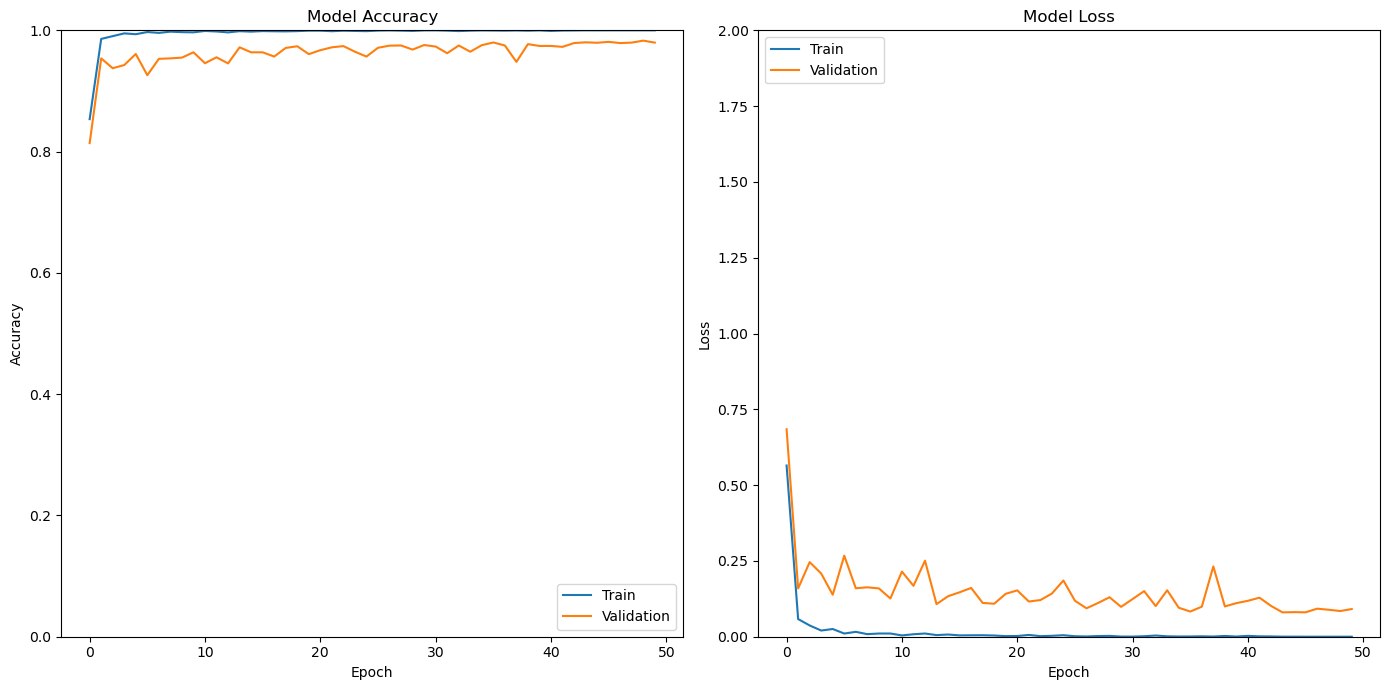

In [16]:
plot_accuracy_and_loss(history)

As we can see, the model is converging nicely. <br>

# 12. Load and evaluate the best model on whole validation data

In [22]:
best_model = keras.models.load_model(os.path.join(HOME_DIR, "best_model.h5"))
score = best_model.evaluate(validation_generator, verbose=1)
print("Validation loss:", score[0])
print("Validation accuracy:", score[1])

246/246 [==============================] - 6s 22ms/step - loss: 0.0918 - accuracy: 0.9793
Validation loss: 0.09182924777269363
Validation accuracy: 0.9793393611907959


# 13. Test the model on test data

In [23]:
predict = best_model.predict(test_dataset, verbose=1)
predict = np.argmax(predict, axis=1)

print("Accuracy on test set:", accuracy_score(ground_truth, predict))

395/395 [==============================] - 6s 15ms/step
Accuracy on test set: 0.9783056215360253


We are getting same accuracy of 98% on the test and the validation data. <br>
This means that our model is not overfitting and it is generalizing well. <br>

# 14. Confusion matrix

In [24]:
def plot_confusion_matrix(ground_truth, predict):
    cm = confusion_matrix(ground_truth, predict)
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, cmap=plt.cm.RdPu)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks(np.arange(NUM_CLASSES))
    plt.yticks(np.arange(NUM_CLASSES))
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.show()

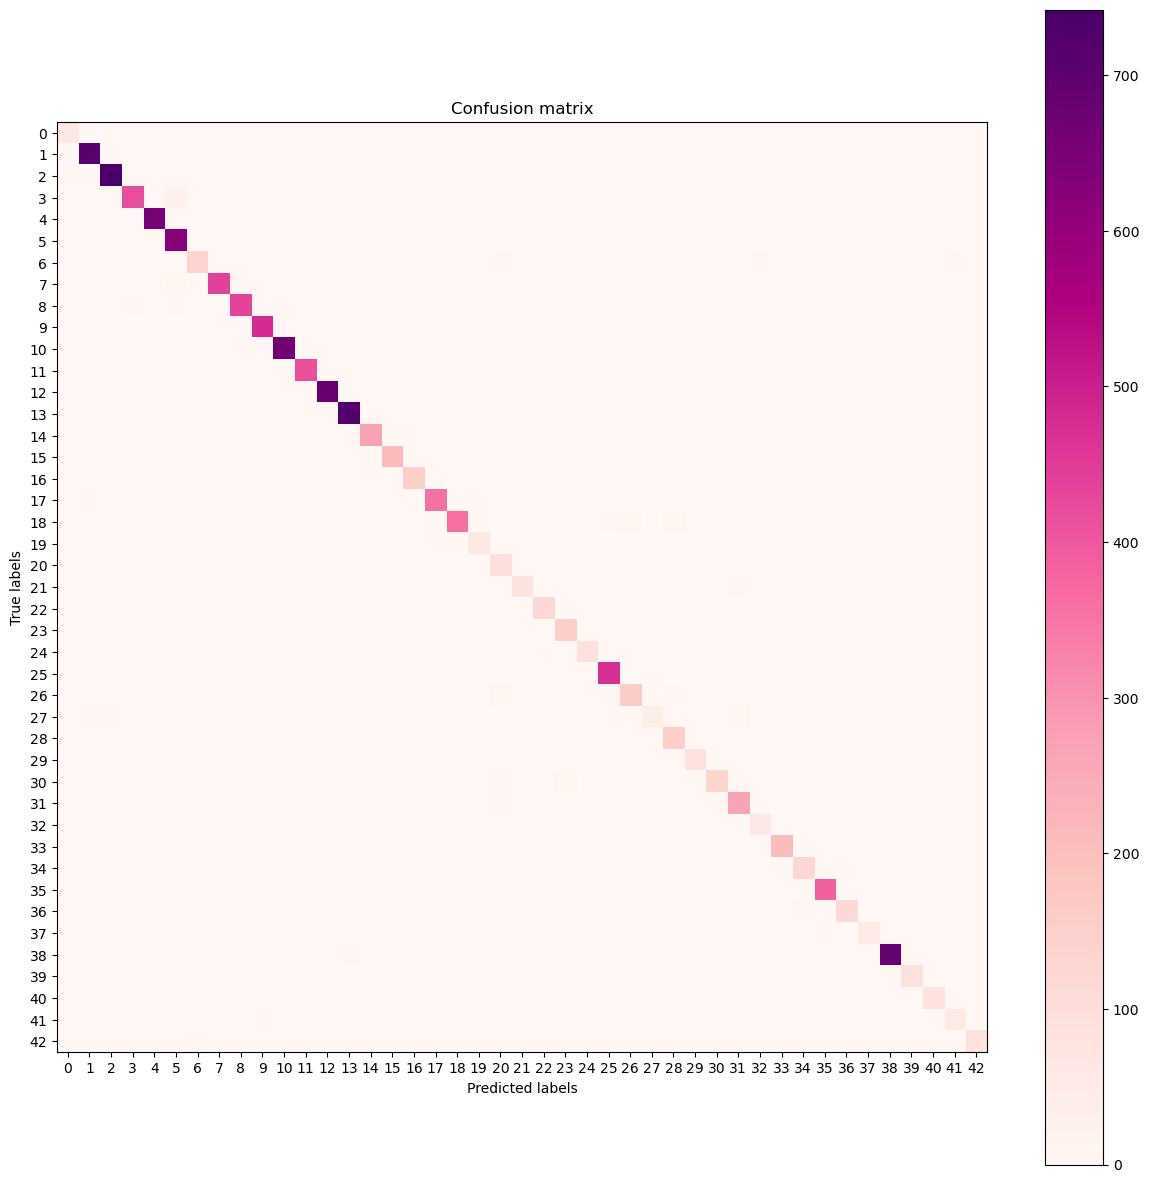

In [25]:
plot_confusion_matrix(ground_truth, predict)

Since the data is not balances, the model could be biased towards the classes with more images. <br>
Lets check F1 score, precision and recall. <br>

# 15. F1, precision and recall scores

In [28]:
f1 = f1_score(ground_truth, predict, average="macro")
precision = precision_score(ground_truth, predict, average="macro")
recall = recall_score(ground_truth, predict, average="macro")

print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

F1 score: 0.9653868115166957
Precision: 0.9693935675015183
Recall: 0.9640367313845575


It looks like the model is not biased towards the classes with more images. <br>